# Image classifier project
In this project, an image classifier, built with TensorFlow, is trained to recognize different species of flowers. First the classifier is trained using the MobileNet pre-trained image classifier network.  The trained model is exported and the model is used in a commandline Python application recognizing flower image. The project uses the dataset [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories.A few examples below. 

<img src='assets\Flowers.png' width="500" />

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on the dataset.
* Use trained model to perform inference on flower images. ('predict' function)


## Import Resources

In [161]:
# Make all necessary imports.
import time
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()


import numpy as np
import matplotlib.pyplot as plt

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 TensorFlow Datasets version:', tfds.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.config.list_physical_devices('GPU') else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.2.0
	• TensorFlow Datasets version: 3.1.0
	• tf.keras version: 2.3.0-tf
	• Running on GPU


## Load the Dataset

Here `tensorflow_datasets` is used to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  

The training data is normalized and resized to 224x224 pixels as required by the pre-trained Mobilenet network.

In [162]:
# Load the dataset with TensorFlow Datasets.
#all = tfds.Split.Train + tfds.Split.Test + tfds.Split.Validation
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True,data_dir ='E:\ekuum\data\Tensorflow_dataset')

# Check dataset_info
dataset_info

# Create a training set, a validation set and a test set.
data_train = dataset['train']
data_valid = dataset['validation']
data_test = dataset['test']


In [163]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

## Explore the Dataset

In [165]:
# Get the number of examples in each set from the dataset info.
num_training_examples = dataset_info.splits['train'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('There are {:,} images in the test set'.format(num_test_examples))

# Get the number of classes in the dataset from the dataset info.
num_label_classes = dataset_info.features['label'].num_classes

# Load dataset info about class labels 
class_names = dataset_info.features['label'].names
print('There are {:,} classes in the data set'.format(len(class_names)))

There are 1,020 images in the training set
There are 1,020 images in the validation set
There are 6,149 images in the test set
There are 102 classes in the data set


In [166]:
# Print the shape and corresponding label of 3 sample images in the training set.
for image_batch, label_batch in data_train.take(3):
    print('\u2022 Example image -  shape:', image_batch.shape, '\tlabel nr:', label_batch.numpy(), '\t label name:', class_names[label_batch.numpy()])


• Example image -  shape: (500, 667, 3) 	label nr: 72 	 label name: water lily
• Example image -  shape: (500, 666, 3) 	label nr: 84 	 label name: desert-rose
• Example image -  shape: (670, 500, 3) 	label nr: 70 	 label name: gazania


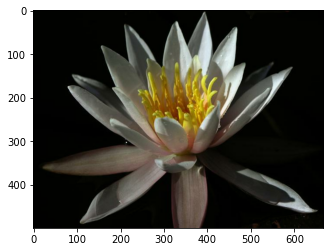

The label of this image is: 72


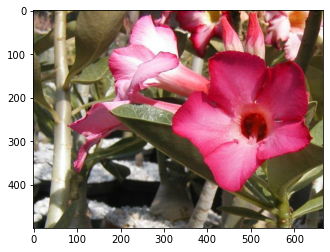

The label of this image is: 84


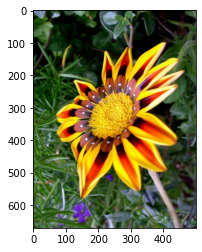

The label of this image is: 70


In [168]:
# Plot 3 sample image from the training set. Set the title 
# of the plot to the corresponding image label. 
for image_batch, label_batch in data_train.take(3):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

    # Plot the image
    plt.imshow(images)
    plt.show()

    print('The label of this image is:', labels)

### Label Mapping
Flower names mapping to each image integer coded label is available in the dataset. TThis will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [169]:
class_names = dataset_info.features['label'].names

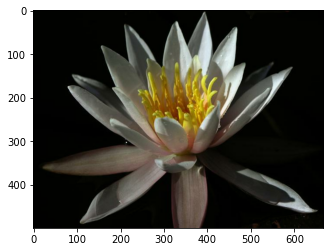

The label of this image is: water lily


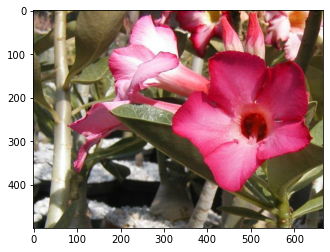

The label of this image is: desert-rose


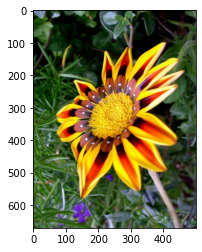

The label of this image is: gazania


In [170]:
# Plot 3 sample image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image_batch, label_batch in data_train.take(3):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

    # Plot the image
    plt.imshow(images)
    plt.show()

    print('The label of this image is:', class_names[labels])


## Create Pipeline

In [171]:
# Create a pipeline for each set.

# Set image batch size parameters and image size
BATCH_SIZE = 64
IMG_SHAPE = 224

# Build parsing functions to normalize image values and resize images to same shape & size
def parse_function(image, label):
    # Normalize image to float values in [0,1]
    image = tf.cast(image, tf.float32)
    image /= 255

    # Resize image to same size and shape
    image = tf.image.resize(image, [IMG_SHAPE, IMG_SHAPE])

    return image, label

# Create training, validation and test batches 
training_batches = data_train.cache().shuffle(num_training_examples//4).map(parse_function).batch(BATCH_SIZE).prefetch(1)
validation_batches = data_valid.cache().shuffle(num_training_examples//4).map(parse_function).batch(BATCH_SIZE).prefetch(1)
test_batches = data_test.cache().shuffle(num_training_examples//4).map(parse_function).batch(BATCH_SIZE).prefetch(1)


# Build and Train the Classifier

MobileNet pre-trained model from TensorFlow Hub is used to get the image features. A new feed-forward classifier is build using the features identified by MobileNet network.

The following steps are executed:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save trained model as a Keras model. 


In [172]:
# Build and train the network.

# Load pretrained MobileNet and freeze weights and biases in pre-trained model
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE,3))
feature_extractor.trainable = False

# Build new model based on pretrained MobileNet and new classification layer with output layer size match with num_of_label_classes, i.e. each output neuron matches with one label class
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_label_classes, activation = 'softmax')
]

# Check model structure
model.summary()

# Set model training parameters
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Use 30 training epochs
EPOCHS = 30

# Fit training data to the model; use the validation data and capture the training history
history = model.fit(training_batches, 
                    epochs=EPOCHS, 
                    validation_data=validation_batches)
    

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_6 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/30
16/16 [==============================] - 6s 358ms/step - loss: 4.5039 - accuracy: 0.0598 - val_loss: 3.6392 - val_accuracy: 0.2382
Epoch 2/30
16/16 [==============================] - 5s 285ms/step - loss: 2.8004 - accuracy: 0.5402 - val_loss: 2.6348 - val_accuracy: 0.5578
Epoch 3/30
16/16 [==============================] - 4s 281ms/step - loss: 1.7694 - accuracy: 0.8157 - val_loss: 2.0040 - val_accuracy: 0.6775
Epoch 4/30
16/16 [==============================] - 4s 268ms/step - loss: 

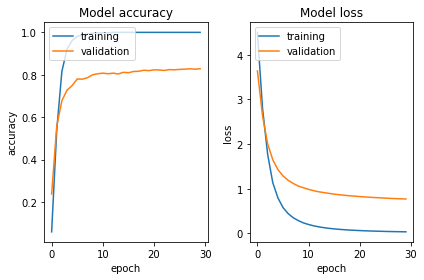

In [173]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Testing the Network performance 

Use testing dataset to evaluate model performance (loss and accuracy). Check model performance with a set of sample images from the testing dataset.

In [176]:
# Print the loss and accuracy values achieved on the entire test set.
test_loss, test_accuracy = model.evaluate(test_batches)
print('Test loss: %.2f, test accuracy: %.2f' %(test_loss, test_accuracy))



97/97 [==============================] - 14s 144ms/step - loss: 0.8941 - accuracy: 0.7798
Test loss: 0.89, test accuracy: 0.78


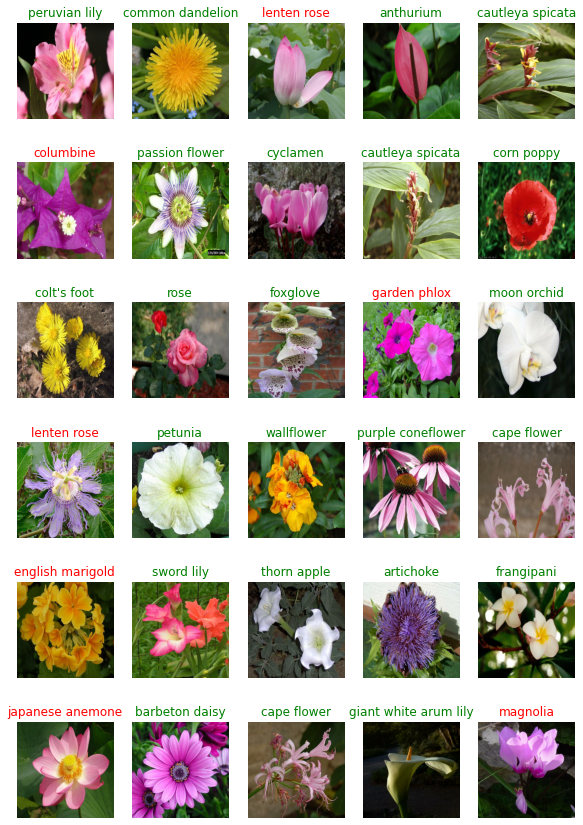

In [177]:
# Print examples of prediction classification through sample set
for image_batch, label_batch in test_batches.take(3):
    ps = model.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n])
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')

## Save the Model

Trained model saved as a Keras model (HDF5 formatted file).

In [178]:
# Save your trained model as a Keras model. Give timestamp for the model.
t = time.time()

saved_keras_model_filepath = './flower_classifier_model_{}.h5'.format(int(t))
tf.keras.models.save_model(model, saved_keras_model_filepath, save_format = 'h5')

## Load the Keras Model

Re-load the Keras model to test it works properly.

In [179]:
# Load the Keras model
print(saved_keras_model_filepath)
reloaded_model = tf.keras.models.load_model(saved_keras_model_filepath, custom_objects={'KerasLayer':hub.KerasLayer})
reloaded_model.summary()


./flower_classifier_model_1590939931.h5
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_6 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Function 'predict' is build that uses trained network for inference. Function takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function is:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

`predict` function uses `PIL` to load the image from the given `image_path`. [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function is used to load the images. The `Image.open()` function returns an `Image` object. `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function also handles the pre-processing the input image such that it can be used by the trained model model. Separate function called `process_image` performs the pre-processing. 

### Image Pre-processing

The `process_image` function takes in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, image is converted into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are encoded as integers in the range 0-255, and will be normalized to be floats in the range 0-1. 

Finally, images are converted back to a NumPy array using the `.numpy()` method.

In [180]:
# The process_image function

def process_image(image):
    # Convert numpy array to TF image
    tf_image = tf.convert_to_tensor(image)

    # Normalize image to float values in [0,1]
    tf_image = tf.cast(tf_image, tf.float32)
    tf_image /= 255

    # Resize the image to match flower classifier model input size (224 x 224 x 3):
    tf_image = tf.image.resize(tf_image, [IMG_SHAPE, IMG_SHAPE])
   
    # Convert tensorflow image back to numpy array and return the image
    return tf.keras.preprocessing.image.img_to_array(tf_image)


Testing of the `process_image` function with 4 sample images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by `process_image` function.

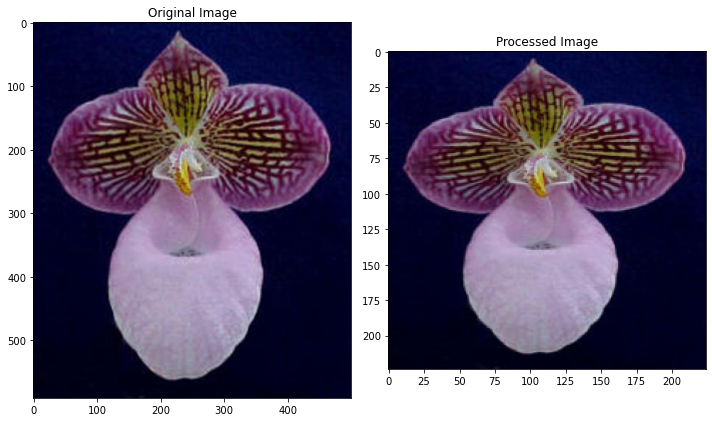

In [181]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

### Inference

Build the 'predict' function: 
```python
probs, classes = predict(image_path, model, top_k)
```

In [182]:
# The predict function
def predict(image_path, model, top_k):
    # Load the image
    im = Image.open(image_path)
    test_image = np.asarray(im)

    # Process image to fit the prediction model (normalize, resize and add extra dimension to represent the batch size for the model, i.e. from (224,224,3) to (1,224,224,3))
    processed_test_image = np.expand_dims(process_image(test_image), axis=0)

    # Use the model and make prediction of the image classes
    model_prediction = model.predict(processed_test_image).squeeze()

    # Identify top k labels, with highest prediction probability
    top_k_labels = np.argpartition(model_prediction, -top_k)[-top_k:]
    top_k_label_probabilities = model_prediction[top_k_labels] 

    # return the array containg the top k label numbers and the probabilities of respective labels
    return top_k_label_probabilities, top_k_labels

# Testing the predict function / sanity check

The predict function is tested with provided 4 sample images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

Test plots the image, image name (flower name) and the top5 categories predicted by the model.

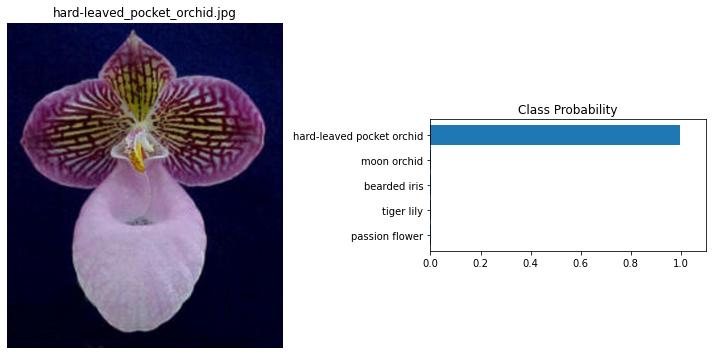

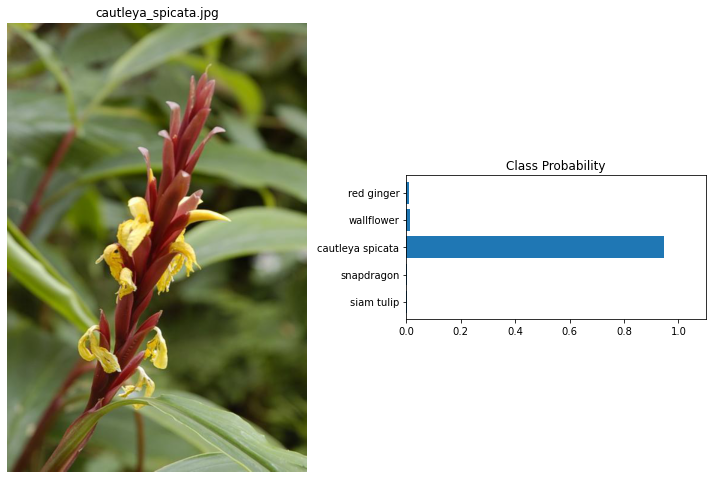

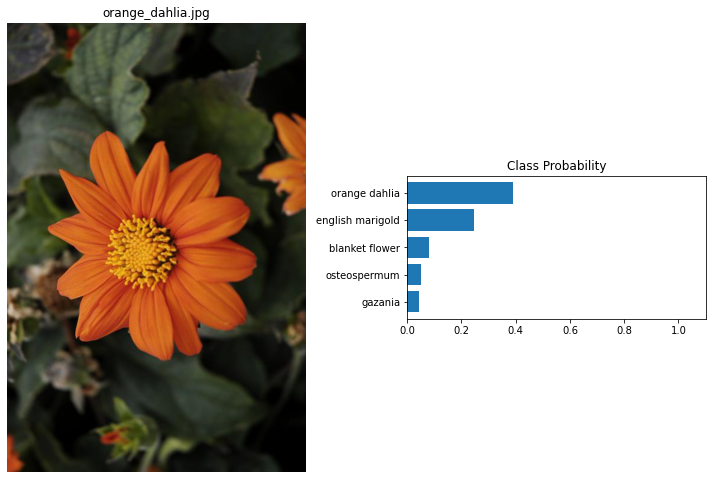

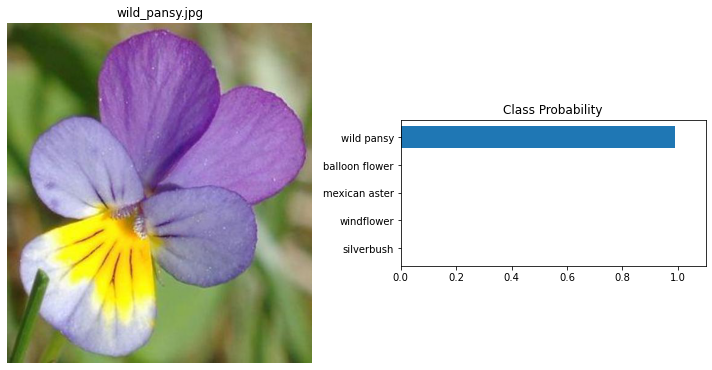

In [188]:
#  Plot the input image along with the top 5 classes

# Calculate the prediction of top 5 classess for a given test image
image_paths = ['hard-leaved_pocket_orchid.jpg', 'cautleya_spicata.jpg', 'orange_dahlia.jpg','wild_pansy.jpg']

for image_path in image_paths:
    top_k = 5
    probs, classes = predict('./test_images/' + image_path, reloaded_model, top_k)
 
    # Load the image
    im = Image.open('./test_images/' + image_path)
    test_image = np.asarray(im)

    # Plot the image and class probability
    fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
    ax1.imshow(test_image)
    ax1.axis('off')
    ax1.set_title(image_path)
    ax2.barh(np.arange(top_k), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(top_k))
    ax2.set_yticklabels(np.array(class_names)[classes])
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
